In [2]:
import pandas as pd
df_data = pd.read_csv('flights.csv', low_memory=False)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [3]:
df = df_data.copy()

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def prep_data(df):
    
    df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype(str)
    df['DESTINATION_AIRPORT'] = df['DESTINATION_AIRPORT'].astype(str)
        
    delay = []
    for row in df['ARRIVAL_DELAY']:
        if row > 60:
            delay.append(3)
        elif row > 30:
            delay.append(2)
        elif row > 15:
            delay.append(1)
        else:
            delay.append(0)
    df['DELAY'] = delay
    df = df.drop([
        'ARRIVAL_DELAY', 'SECURITY_DELAY', 'TAXI_OUT', 'TAXI_IN', 
        'WHEELS_OFF', 'WHEELS_ON', 'AIR_TIME', 'ELAPSED_TIME', 'ARRIVAL_TIME', 
        'DEPARTURE_TIME', 'CANCELLED', 'CANCELLATION_REASON' , "DIVERTED", 'DAY', 'YEAR','MONTH', 'SCHEDULED_TIME', 'AIRLINE', 'DISTANCE', 'DAY_OF_WEEK'
    ], axis=1)
    
    for column in df.columns:
        if df[column].dtype == 'object':  # Check if the column is categorical
            df[column] = label_encoder.fit_transform(df[column])

    df.dropna(how='any', inplace=True)
    return df


In [5]:
df = prep_data(df)

In [6]:
df.head(10)

,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,AIR_SYSTEM_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAY
27,597,2141,522,421,115,12.0,542,25.0,0.0,0.0,0.0,1
30,168,2722,545,535,125,72.0,549,43.0,0.0,0.0,0.0,2
35,17,1289,480,448,145,0.0,555,0.0,15.0,0.0,0.0,0
50,1030,678,348,500,307,-3.0,500,20.0,0.0,0.0,0.0,1
52,2134,874,591,500,400,95.0,605,0.0,85.0,0.0,0.0,3
55,2276,2827,591,333,438,72.0,739,17.0,72.0,0.0,0.0,3
70,1057,1357,392,510,515,108.0,856,0.0,0.0,0.0,102.0,3
73,425,436,542,546,520,60.0,850,0.0,60.0,0.0,0.0,2
74,89,1557,457,510,520,58.0,841,0.0,54.0,0.0,0.0,2
86,328,1973,391,393,530,53.0,835,13.0,53.0,0.0,0.0,3


In [7]:
df = df.drop(['DEPARTURE_DELAY', 'LATE_AIRCRAFT_DELAY'], axis=1)

In [8]:
# Import necessary libraries for data splitting, scaling, and classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extracting features and target variables from the dataset
X = df.iloc[:, :-1].values  # Features (all columns except the last)
Y = df.iloc[:, -1].values   # Target variable (the last column)

# Splitting the data into training and testing sets (70% train, 30% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Standardizing the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, mean_absolute_error, mean_squared_error, r2_score

# Initialize the classifiers
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()

model_list = [dtc, rfc]
# Initialize an empty list to store the results
results_list = []

# Loop over each classifier
for model in model_list:
    model_name = model.__class__.__name__
    print(f"Training model: {model_name}")

    # Train the classifier
    model.fit(X_train_scaled, Y_train)

    # Predict the test set
    y_pred = model.predict(X_test_scaled)

    # Calculate regression metrics
    mae = mean_absolute_error(Y_test, y_pred)
    mse = mean_squared_error(Y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, y_pred)
    rmsle = np.log(np.sqrt(mse))

    # Calculate classification metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    # Calculate AUC score if applicable (for binary or multilabel)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)
        auc = roc_auc_score(Y_test, y_prob, multi_class='ovr')
    else:
        auc = None

    # Print metrics
    print(f"Accuracy of {model_name}: {round(accuracy, 3)}")
    print(f"Classification Report for {model_name}:")
    print(classification_report(Y_test, y_pred))
    if auc is not None:
        print(f"AUC Score for {model_name}: {round(auc, 3)}")

    print(f'MAE: {round(mae, 3)}')
    print(f'MSE: {round(mse, 3)}')
    print(f'RMSE: {round(rmse, 3)}')
    print(f'R2 Score: {round(r2, 6)}')
    print(f'RMSLE: {round(rmsle, 3)}')

    # Adjusted R-squared calculation to account for the number of features
    adjusted_r2 = 1 - (1 - r2) * (len(Y_test) - 1) / (len(Y_test) - X_test.shape[1] - 1)
    print(f'Adjusted R2 Score: {round(adjusted_r2, 6)}')

    print('------------------------------------------------------------')

    # Append the results to the list
    results_list.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 3),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3),
        'AUC': round(auc, 3) if auc is not None else None,
        'MAE': round(mae, 3),
        'MSE': round(mse, 3),
        'RMSE': round(rmse, 3),
        'R2 Score': round(r2, 6),
        'RMSLE': round(rmsle, 3),
        'Adjusted R2 Score': round(adjusted_r2, 6)
    })

results = pd.DataFrame(results_list)

Training model: DecisionTreeClassifier
Accuracy of DecisionTreeClassifier: 0.617
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49     11995
           1       0.66      0.65      0.66    117172
           2       0.57      0.57      0.57     94012
           3       0.63      0.64      0.63     95853

    accuracy                           0.62    319032
   macro avg       0.59      0.59      0.59    319032
weighted avg       0.62      0.62      0.62    319032

AUC Score for DecisionTreeClassifier: 0.725
MAE: 0.516
MSE: 0.801
RMSE: 0.895
R2 Score: -0.003397
RMSLE: -0.111
Adjusted R2 Score: -0.003425
------------------------------------------------------------
Training model: RandomForestClassifier
Accuracy of RandomForestClassifier: 0.68
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58    

In [13]:
results.head()

,Model,Accuracy,Precision,Recall,F1 Score,AUC,MAE,MSE,RMSE,R2 Score,RMSLE,Adjusted R2 Score
0,DecisionTreeClassifier,0.617,0.617,0.617,0.617,0.725,0.516,0.801,0.895,-0.003397,-0.111,-0.003425
1,RandomForestClassifier,0.680,0.689,0.680,0.676,0.872,0.428,0.652,0.807,0.183231,-0.214,0.183208


In [22]:
results.to_csv('Results_Classification.csv')

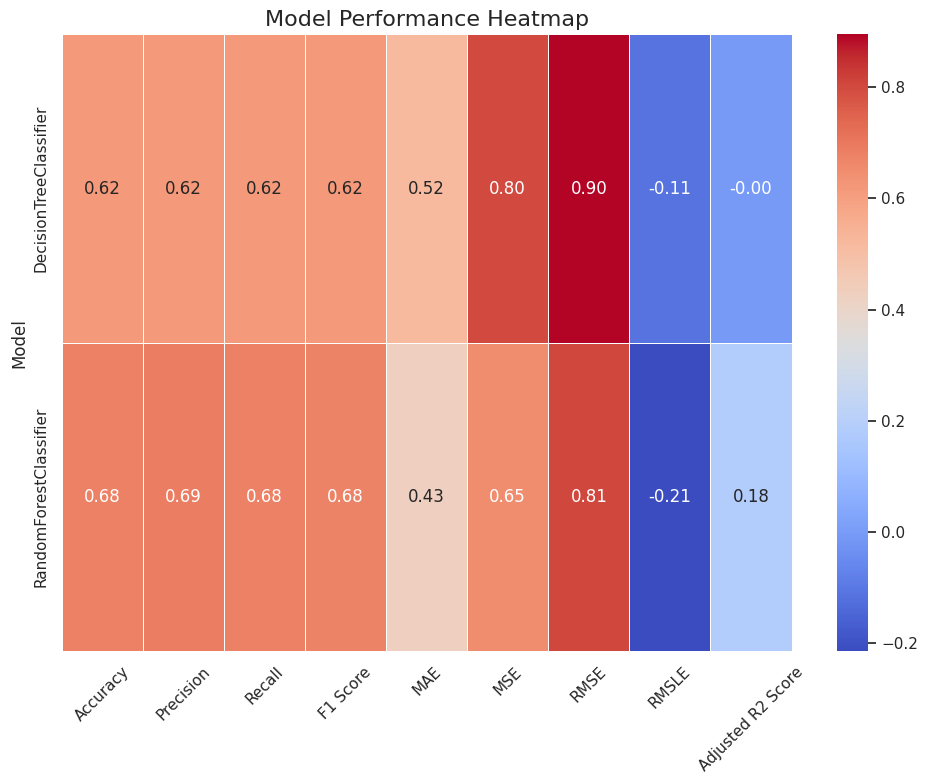

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for metrics to be plotted in a heatmap
heatmap_df = results.set_index('Model')

# Select metrics for the heatmap
metrics_for_heatmap = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'Adjusted R2 Score']

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df[metrics_for_heatmap], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Model Performance Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


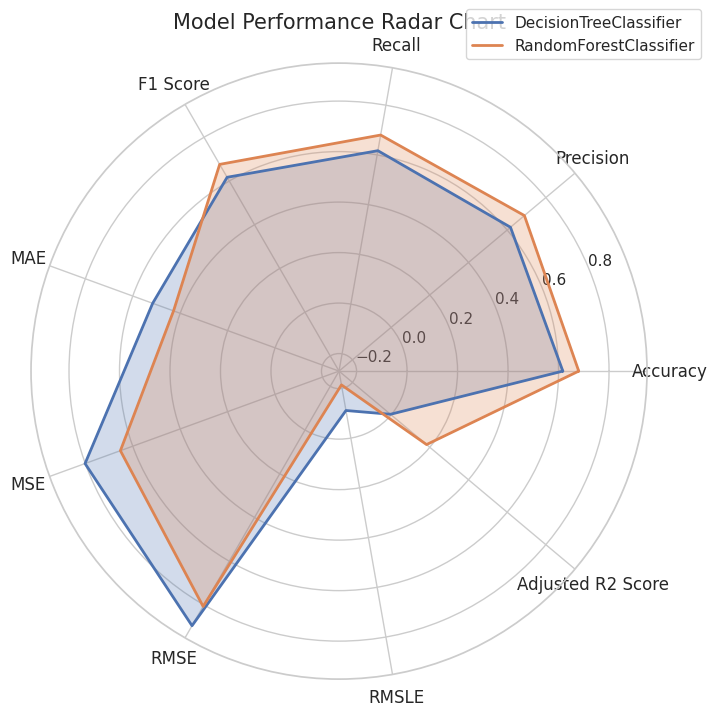

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create a radar chart
def create_radar_chart(df, metrics, models):
    labels = metrics
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    # Set up the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each model
    for i, model in enumerate(models):
        values = df.loc[model, metrics].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)

    # Labels for each axis
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    plt.title('Model Performance Radar Chart', size=15)
    
    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()

# Metrics and models for the radar chart
metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MAE', 'MSE', 'RMSE', 'RMSLE', 'Adjusted R2 Score']
models_for_radar = results['Model']

# Call the radar chart function
create_radar_chart(heatmap_df, metrics_for_radar, models_for_radar)


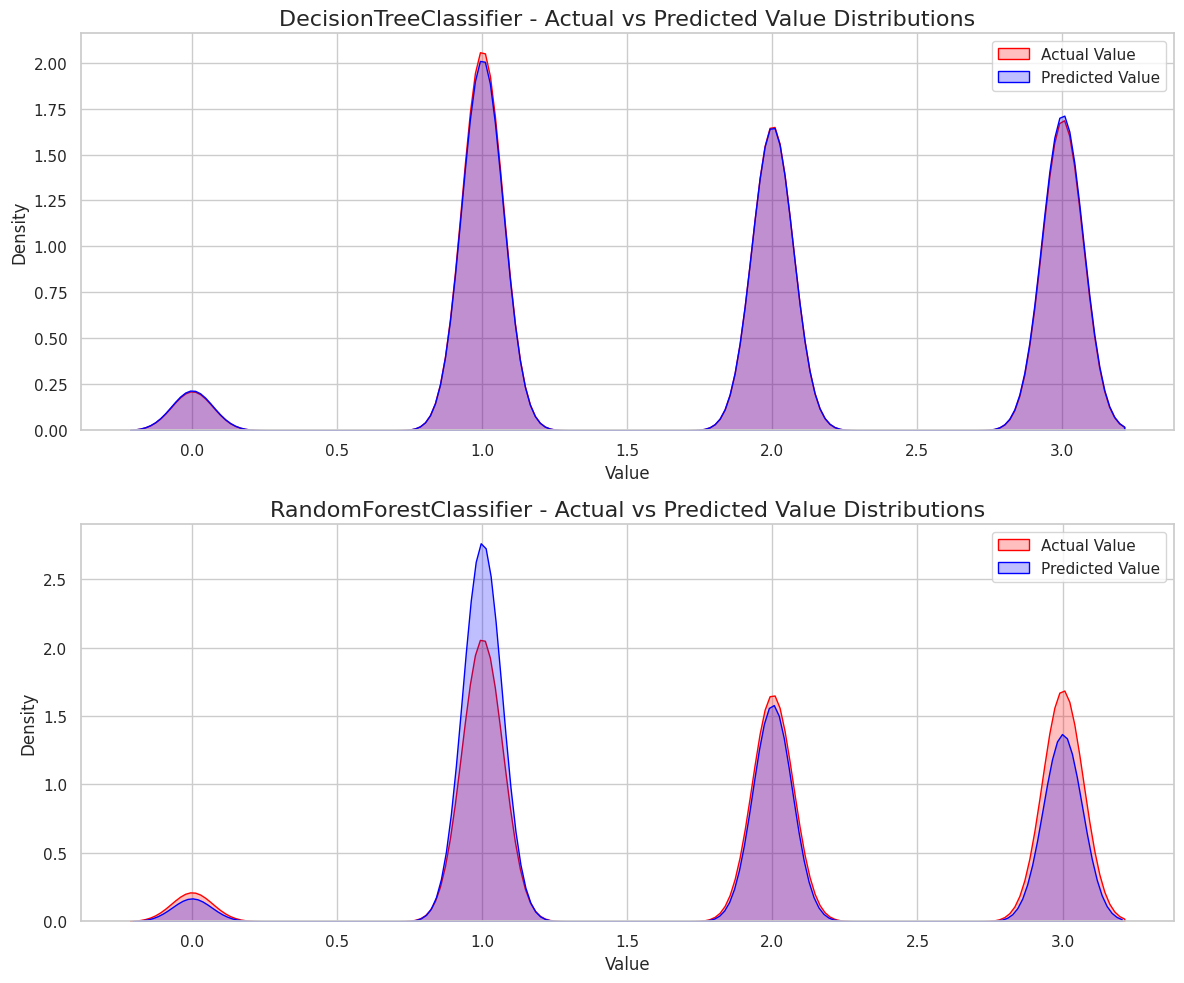

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots grid to compare all models at once
num_models = len(model_list)
fig, axes = plt.subplots(nrows=num_models, figsize=(12, 5 * num_models))  # Create grid with n rows

# If there is only one model, we need to wrap the single axis in a list to handle it the same way
if num_models == 1:
    axes = [axes]

# Loop over each model and corresponding axis
for i, model in enumerate(model_list):
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Creating a DataFrame to store actual and predicted values side by side
    output_df = pd.DataFrame({'Actual_Value': Y_test, 'Predicted_Value': y_pred})

    # Visualize predictions for each model
    sns.kdeplot(output_df['Actual_Value'], label='Actual Value', color='red', fill=True, ax=axes[i])
    sns.kdeplot(output_df['Predicted_Value'], label='Predicted Value', color='blue', fill=True, ax=axes[i])

    # Set the title, labels, and legend for each subplot
    axes[i].set_title(f'{model.__class__.__name__} - Actual vs Predicted Value Distributions', fontsize=16)
    axes[i].set_xlabel('Value', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend()

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()
